In [0]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import datasets,transforms
import torch.nn.functional as F
import cv2
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
classes=[]
images=[]
for folder in os.listdir('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/training'):
    path=os.path.join('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/training',folder)
    for image in os.listdir(path):
        images.append(os.path.join(path,image))
        classes.append(folder)
encoder={}
for i,label in (enumerate(os.listdir('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/training'))):
  encoder[label]=i
class ImageFolder(Dataset):
    def __init__(self,classes,images,transform=None,encoder=None):
        self.transform=transform
        self.encoder=encoder
        self.classes=classes
        self.images=images
    def __getitem__(self,idx):
      image=Image.open(self.images[idx])
      image = np.asarray(image)
      image=torch.from_numpy(image)
      label=self.classes[idx]
      if self.transform:
        image=self.transform(image)
      return image,encoder[label]
    def __len__(self):
      return len(self.images)

        



In [0]:
class SiameseDataset(Dataset):
  def __init__(self,trainloader):
    self.trainloader=trainloader

  def __getitem__(self,idx):
    image1,label1=next(iter(self.trainloader))
    should_get_same_class = random.randint(0,1) 
    if should_get_same_class:
      while True:
        image2,label2=next(iter(self.trainloader))
        if int(label1)==int(label2):
          break
    else:
      while True:
        image2,label2=next(iter(self.trainloader))
        if int(label1)!=int(label2):
          break
    
    return image1, image2 , torch.from_numpy(np.array([int(label1!=label2)],dtype=np.float32))

  def __len__(self):
    return len(self.trainloader)
        



In [0]:
import random

In [0]:
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((100, 100)), 
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))
                    ])

In [0]:
dataset = ImageFolder(classes, images ,transform,encoder)
trainloader = DataLoader(dataset,batch_size = 1,shuffle = True)
new_train=SiameseDataset(trainloader)
trainloader=DataLoader(new_train,batch_size=8,shuffle=True)

tensor([0.])


torch.Size([8, 1, 100, 100])

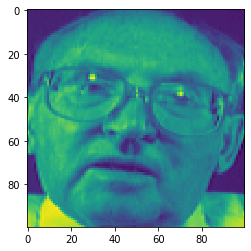

In [9]:
image1,image2,label=next(iter(trainloader))
print(label[0])
#print(int(label))
image1=image1.view(8,-1,100,100)
plt.imshow(image1[0][0])
image2=image2.view(8,-1,100,100)
plt.imshow(image2[0][0])
image1.shape


In [0]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork,self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [0]:
counter = []
loss_history = [] 
iteration_number= 0

In [0]:
for epoch in range(0,100):
    for i, data in enumerate(trainloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        img0=img0.view(-1,1,100,100)
        img1=img1.view(-1,1,100,100)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [0]:

imagetest=[]
for folder in os.listdir('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/testing'):
    path=os.path.join('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/testing',folder)
    for image in os.listdir(path):
        imagetest.append(os.path.join(path,image))
#        classes.append(folder)
#encoder={}
#for i,label in (enumerate(os.listdir('/content/Facial-Similarity-with-Siamese-Networks-in-Pytorch-master/data/faces/testing'))):
#  encoder[label]=i
class ImageTest(Dataset):
    def __init__(self,images,transform=None):
        self.transform=transform
        self.images=images
    def __getitem__(self,idx):
      image=Image.open(self.images[idx])
      image = np.asarray(image)
      image=torch.from_numpy(image)
      #label=self.classes[idx]
      if self.transform:
        image=self.transform(image)
      return image
    def __len__(self):
      return len(self.images)

class SiameseTest(Dataset):
  def __init__(self,trainloader):
    self.trainloader=trainloader

  def __getitem__(self,idx):
    image1=next(iter(self.trainloader))
    should_get_same_class = random.randint(0,1) 
    image2=next(iter(self.trainloader))
    return image1, image2
  def __len__(self):
      return len(self.trainloader) 

        



In [0]:
test = ImageTest(imagetest ,transform)
testloader = DataLoader(test,batch_size = 1,shuffle = True)
new_test=SiameseTest(testloader)
testloader=DataLoader(new_test,batch_size=1,shuffle=True)

In [0]:
img1,img2=next(iter(testloader))
img1=img1.view(-1,1,100,100)
img2=img2.view(-1,1,100,100)
concatenated = torch.cat((img1,img2),0)

In [0]:
output1,output2 = net(img1.cuda(),img2.cuda())
euclidean_distance = F.pairwise_distance(output1, output2)


In [0]:
import torchvision
batch_tensor = torch.randn(*(10, 3, 256, 256))
grid_img = torchvision.utils.make_grid(batch_tensor)
batch_tensor.shape
concatenated.shape
x=torchvision.utils.make_grid(concatenated)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


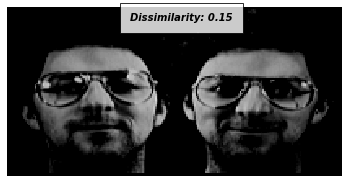

In [55]:
imshow(x,'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


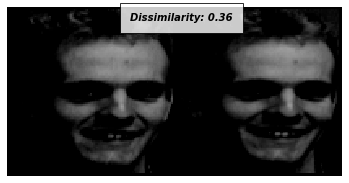

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


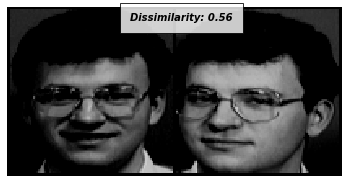

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


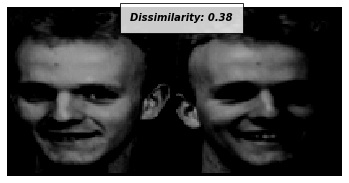

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


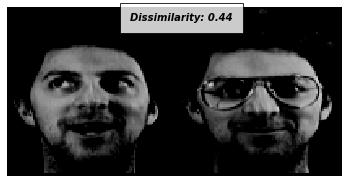

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


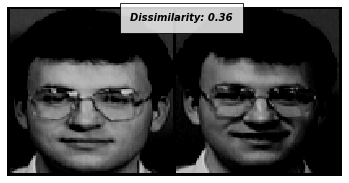

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


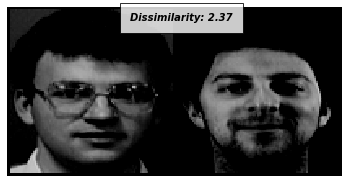

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


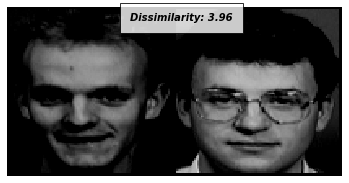

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


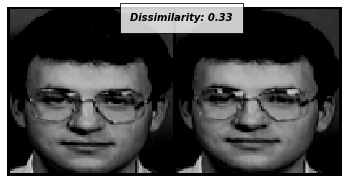

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


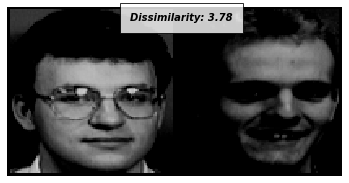

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


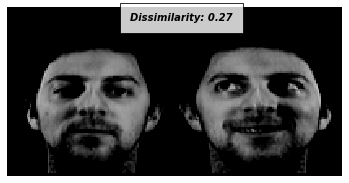

In [56]:
for i in range(10):
    img1,img2= next(iter(testloader))
    img1=img1.view(-1,1,100,100)
    img2=img2.view(-1,1,100,100)
    concatenated = torch.cat((img1,img2),0)
    
    output1,output2 = net(img1.cuda(),img2.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    x=torchvision.utils.make_grid(concatenated)
    imshow(x,'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))